In [1]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn import L1Loss
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

import warnings
warnings.filterwarnings('ignore')

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functools import partial

from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head(3)

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN


In [6]:
def compute_rdkit_feats(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {}
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    
    for i in range(1, maccs.GetNumBits()):  # bit 0 is always 1
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))

    # Descriptors
    descs = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
        'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
        'NumRings': Descriptors.RingCount(mol),
        'NumRotatableBonds': CalcNumRotatableBonds(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'MolMR': Descriptors.MolMR(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }
    features.update(descs)

    return features

In [7]:
maccs_data = []

for smile in tqdm(train['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data.append(None)
    else:
        maccs_data.append(feats)
        
maccs_df = pd.DataFrame(maccs_data)
train_rdkit = pd.concat([train, maccs_df], axis=1)

  0%|          | 0/7973 [00:00<?, ?it/s]

In [8]:
train_rdkit.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg,MACCS_1,MACCS_2,MACCS_3,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,0,0,0,...,232.323,26.30,92,17,1,8,3.98170,68.4145,2,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,0,0,0,...,598.919,24.06,236,45,5,16,12.35960,193.3954,2,2
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,0,0,0,...,1003.207,122.27,364,73,10,15,14.21700,281.6006,9,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,0,0,0,...,542.726,24.06,204,42,6,7,11.00768,179.8154,2,2
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,0,0,0,...,965.154,182.28,376,70,6,34,11.84500,266.9958,14,0


In [9]:
class NeurIPSDS(Dataset):
    def __init__(self, df, feats, targ):
        self.X = df[feats].astype('float32').values
        self.y = df[targ].astype('float32').values
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [10]:
feat_cols = train_rdkit.columns.tolist()[7:]
targs = train_rdkit.columns.tolist()[2:7]
bs = 512

In [11]:
targs

['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [12]:
def get_dls(train_ds, val_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
                DataLoader(train_ds, batch_size=bs, shuffle=False, **kwargs))

In [13]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def dls(cls, train_ds, val_ds, bs, **kwargs):
        return cls(*get_dls(train_ds, val_ds, bs=bs, **kwargs))

In [14]:
def get_dataloaders(df, targ, batch_size=16):
    df2 = df.copy()
    df2 = df2[feat_cols + [targ]].dropna()
    scaler = StandardScaler()
    df2[feat_cols] = scaler.fit_transform(df2[feat_cols])
    
    # with open(os.path.join(save_dir, f'{target}_scaler.pkl'), 'wb') as f:
    #         pickle.dump(scaler, f)
    
    train_df, val_df = train_test_split(df2, test_size=0.2, random_state=42)
    
    train_ds = NeurIPSDS(train_df, feat_cols, targ)
    val_ds = NeurIPSDS(val_df, feat_cols, targ)
    
    dls = DataLoaders.dls(train_ds, val_ds, bs)
    
    return dls

In [15]:
dls = get_dataloaders(train_rdkit, 'FFV')

In [16]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [27]:
class LossCB(Callback):
    def __init__(self): self.losses, self.epochs = [], []
    
    def before_fit(self, learn):
        self.losses.clear()
        self.epochs.clear()
        
    def after_epoch(self, learn):
        if not learn.training:
            self.losses.append(learn.loss.item())
            self.epochs.append(learn.epoch)
        print(learn.epoch, learn.loss.item(), 'train' if learn.training else 'eval')
    def after_fit(self, learn):
        plt.plot(self.epochs,self.losses)
        plt.xticks(ticks=self.epochs)

In [28]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=True), astats, LossCB()]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [29]:
def get_one_layer(ni, nf, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not (norm and issubclass(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)))
    layers = [nn.Linear(ni, nf, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [len(feat_cols), 512, 256, 128, 64, 32]
    layers = [get_one_layer(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, get_one_layer(nfs[-1], 1, act=None, norm=None, bias=True)).to(def_device)

In [30]:
model = get_model(act=act_gr, norm=nn.BatchNorm1d).apply(iw)

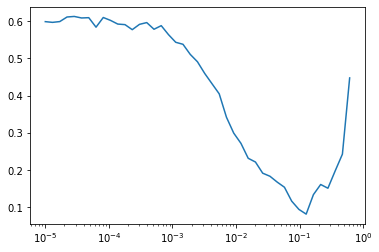

In [31]:
MomentumLearner(model, dls, loss_func=F.l1_loss, cbs=[DeviceCB()]).lr_find()

In [32]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm1d).apply(iw)
learn = TrainLearner(model, dls, F.l1_loss, lr=1e-2, cbs=cbs, opt_func=SGD)

0 0.2699027359485626 train
0 0.22744965553283691 eval
1 0.17202775180339813 train
1 0.1861564666032791 eval
2 0.12330351024866104 train
2 0.11813921481370926 eval
3 0.0993444174528122 train
3 0.08767636120319366 eval
4 0.0779164507985115 train
4 0.07730617374181747 eval
5 0.08039596676826477 train
5 0.06618979573249817 eval
6 0.07364089787006378 train
6 0.06163488328456879 eval
7 0.057278912514448166 train
7 0.05577462539076805 eval
8 0.05709466338157654 train
8 0.05149063095450401 eval
9 0.051089491695165634 train
9 0.047408271580934525 eval


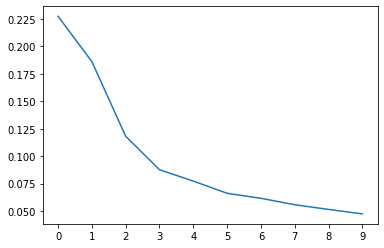

In [33]:
learn.fit(10)

In [34]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom
        
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg * self.mom + (1 - self.mom) * p.grad
        p -= self.lr * p.grad_avg

In [35]:
set_seed(42)
model = get_model(act=act_gr, norm=nn.BatchNorm1d).apply(iw)
learn = TrainLearner(model, dls, loss_func=F.l1_loss, lr=4e-2, cbs=cbs, opt_func=Momentum)

0 0.21320177614688873 train
0 0.13239353895187378 eval
1 0.10109084844589233 train
1 0.08320380747318268 eval
2 0.06394287198781967 train
2 0.053317081183195114 eval
3 0.046558331698179245 train
3 0.04266256093978882 eval
4 0.037888672202825546 train
4 0.036047980189323425 eval
5 0.03806896507740021 train
5 0.031848255544900894 eval
6 0.03203289955854416 train
6 0.028547611087560654 eval
7 0.027227675542235374 train
7 0.027385316789150238 eval
8 0.028755376115441322 train
8 0.026465261355042458 eval
9 0.026012666523456573 train
9 0.026011085137724876 eval


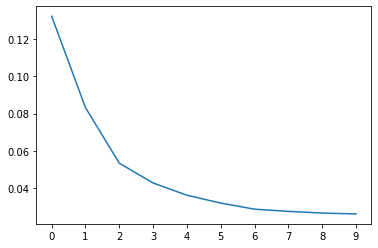

In [36]:
learn.fit(10)

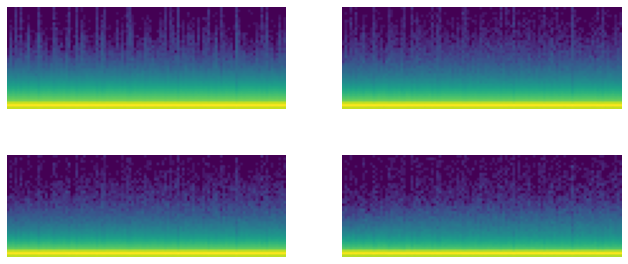

In [37]:
astats.color_dim()

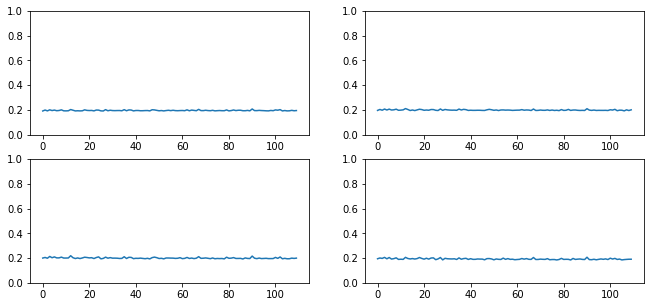

In [38]:
astats.dead_chart()

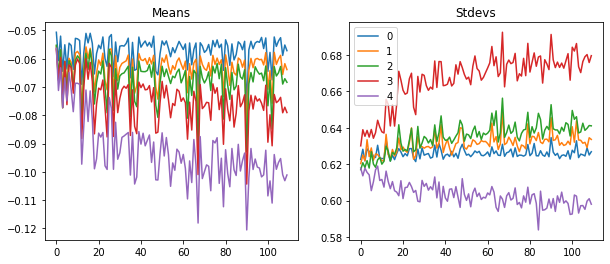

In [39]:
astats.plot_stats()